In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import torch
tt =  torch.tensor
from torch.distributions import TransformedDistribution
import pyro
from pyro.distributions import (
    Bernoulli,
    Beta,
    Binomial,
    Categorical,
    Exponential,
    LKJCorrCholesky,
    LogNormal,
    MultivariateNormal,
    Normal,
    Poisson,
)
from pyro.distributions.transforms import AffineTransform
from pyro.ops.stats import hpdi, quantile, waic
from pyro.infer import Predictive
import arviz as az
import seaborn as sns

from utils import train_nuts, unnest_samples, traceplot

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Oct 02 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

pyro      : 1.9.1
seaborn   : 0.12.2
pandas    : 2.2.2
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
torch     : 2.3.0
arviz     : 0.17.1
matplotlib: 3.9.0
networkx  : 3.1
numpy     : 1.26.4

Watermark: 2.4.3



### Code 15.1
Imagine you have three pancakes, where one has two burnt sides (BB), one has one burn side (BU), and one has two unburnt sides. You are served one of the three at random and notice that the side facing up is burnt. What is the probability that it is the double-burnt pancake? Most people would say 1/2 because if you can see a burnt side, that eliminates the UU pancake, and leaves a choice between two pancakes BU and BB. However, this is not the case. We can see what it is by using Bayes' rule to compute this pretty handily:

$$\begin{align*}
P(BB|B) &= \frac{P(B|BB)P(BB)}{P(B)} = \frac{P(B|BB)P(BB)}{P(B|BB)P(BB) + P(B|BU)P(BU)} \\
&= \frac{1 \times 1/3}{1 \times 1/3 + 1/2 \times 1/3} = \frac{1}{1 + 1/2} = 2/3
\end{align*}$$

If you don't trust this, we can even simulate it!

In [3]:
# simulate 1000 pancakes
# 0=BB, 1=BU, 2=UU
pancakes = np.random.choice(3, 10000)
# for each pancake, simulate whether it is served burnt-side up
p = np.array([1., 0.5, 0.])[pancakes]
burnt_up = np.random.rand(10000) <= p
# what is number of pancakes conditional on burnt side up being observed?
pancakes, counts = np.unique(pancakes[burnt_up], return_counts=True)
for p, c in zip(pancakes, counts):
    print(f"{c} pancakes of type {p}")
print("Fraction of BB pancakes observed:", counts[0]/counts.sum())

3280 pancakes of type 0
1727 pancakes of type 1
Fraction of BB pancakes observed: 0.6550828839624525


### Code 15.2 - 15.7
Back in an earlier chapter, we looked at divorce and marriage data for the United States. At the time, we ignored that there was substantial measurement error in the estimates (since these types of studies are usually done by polling a small sample and then extrapolating out to the whole population). With Bayesian modeling, we can actually incorporate this error into the model itself. Let's visualize these errors before trying to add them to the model.

In [4]:
divorce_df = pd.read_csv("data/WaffleDivorce.csv", sep=";")
divorce_df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


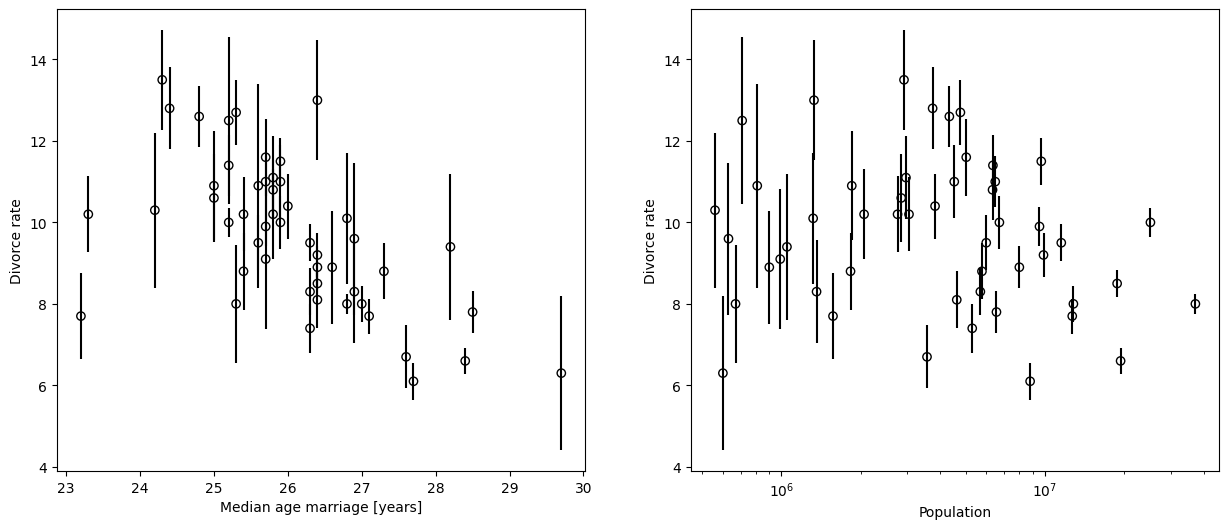

In [5]:
df = divorce_df
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# age vs. divorce
plt.sca(axes[0])
plt.errorbar(df["MedianAgeMarriage"], df["Divorce"], yerr=df["Divorce SE"], fmt="none", color="black")
plt.scatter(df["MedianAgeMarriage"], df["Divorce"], facecolor="none", edgecolor="black")
plt.xlabel("Median age marriage [years]")
plt.ylabel("Divorce rate")
# population vs. divorce
plt.sca(axes[1])
plt.errorbar(1e6*df["Population"], df["Divorce"], yerr=df["Divorce SE"], fmt="none", color="black")
plt.scatter(1e6*df["Population"], df["Divorce"], facecolor="none", edgecolor="black")
plt.xlabel("Population")
plt.ylabel("Divorce rate")
plt.xscale("log")
plt.show()

Notice that the error bars decrease as the population increases...

Recall the causal model of divorce we had earlier ($D \leftarrow A \rightarrow M$ and $M \rightarrow D$). If we now add the measurement error as some kind of outside unobserved factor, that gives us the following DAG:

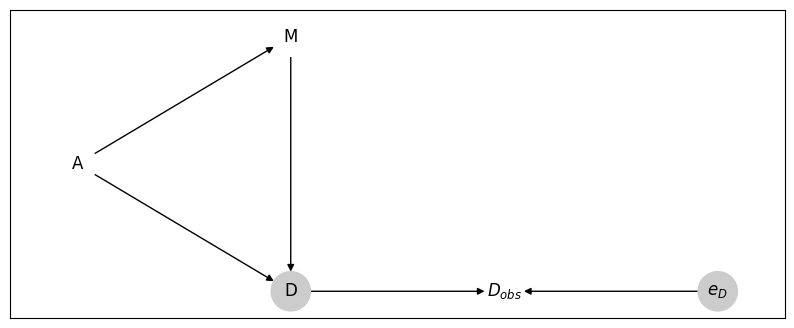

In [6]:
plt.figure(figsize=(10, 4))
G = nx.DiGraph()
G.add_nodes_from([
    ("A", dict(pos=(0, 0.5), color="white")),
    ("M", dict(pos=(1, 1), color="white")),
    ("D", dict(pos=(1, 0), color="#cccccc")),
    ("Dobs", dict(pos=(2, 0), color="white", label=r"$D_{obs}$")),
    ("eD", dict(pos=(3, 0), color="#cccccc", label=r"$e_D$")),
])
G.add_edges_from([("A","M"), ("M","D"), ("A","D"), ("D","Dobs"), ("eD","Dobs")])

c = nx.get_node_attributes(G, "color").values()
pos = nx.get_node_attributes(G, "pos")
labels = {n: G.nodes[n].get("label", n) for n in G.nodes}
nx.draw_networkx(G, pos, labels=labels, node_color=c, node_size=800)
plt.show()

All of our models up until now have used the observed values (like $D_\text{obs}$) as proxies for true values (like $D$). This doesn't necessarily introduce confounding, but it could introduce some kind of systemic bias, distorting the estimate. We could try to reconstruct $D$ by treating $D_{obs}$ as perturbations around it:

$$\begin{align*}
D_{\text{obs},i} &\sim \text{Normal}(D_i, D_{\text{SE},i}) \\
D_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_A, \beta_M &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}$$

In [7]:
def standardize(x):
    return (x - x.mean())/x.std()

df = divorce_df
data = {
    "D_obs": standardize(tt(df["Divorce"].values).double()),
    "D_SE": (tt(df["Divorce SE"].values)/tt(df["Divorce"].values).std()).double(),
    "A": standardize(tt(df["MedianAgeMarriage"].values).double()),
    "M": standardize(tt(df["Marriage"].values).double()),
}

In [8]:
def model_m15_1(data, training=False):
    a = pyro.sample("α", Normal(0., 0.2))
    bA = pyro.sample("βA", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    sigma = pyro.sample("σ", Exponential(1.)).float()
    mu = (a + bA*data["A"] + bM*data["M"]).float()
    D = pyro.sample("D", Normal(mu, sigma))
    if training:
        pyro.sample("D_obs", Normal(D, data["D_SE"]), obs=data["D_obs"])
    else:
        return pyro.sample("D_obs", Normal(D, data["D_SE"]))

In [9]:
m15_1 = train_nuts(model_m15_1, data, 1000, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/3000 [00:00, ?it/s]

Sample: 100%|██████████| 3000/3000 [00:20, 149.20it/s, step size=2.83e-01, acc. prob=0.924]


In [10]:
m15_1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      D[0]      1.17      0.37      1.16      0.57      1.77   3437.03      1.00
      D[1]      0.70      0.53      0.68     -0.12      1.61   2948.60      1.00
      D[2]      0.43      0.33      0.43     -0.08      1.02   3821.54      1.00
      D[3]      1.41      0.47      1.42      0.63      2.11   3399.16      1.00
      D[4]     -0.90      0.13     -0.90     -1.12     -0.69   5830.13      1.00
      D[5]      0.66      0.40      0.65     -0.01      1.31   3332.38      1.00
      D[6]     -1.37      0.34     -1.37     -1.92     -0.83   3955.14      1.00
      D[7]     -0.33      0.46     -0.33     -1.05      0.46   3201.09      1.00
      D[8]     -1.86      0.62     -1.87     -2.91     -0.87   2392.77      1.00
      D[9]     -0.62      0.18     -0.62     -0.93     -0.35   4211.65      1.00
     D[10]      0.77      0.29      0.77      0.32      1.29   3287.24      1.00
     D[11]     -0.54      0

If you look back to the chapter when we did this regression without taking the measurement error into account, the value for $\beta_A$ was about -1; now it's about half that, but the vast majority of the probability mass is still negative. So the association between age and divorce rate has been reduced. Ignoring measurement error tends to exaggerate associations between outcomes and predictors, so this is typical behavior. It might also mask an association as well, so beware!

We should also be aware of shrinkage that will occur in the unobserved "true" divorce rates. Notice that the shrinkage is higher the greater the uncertainty about the data point.

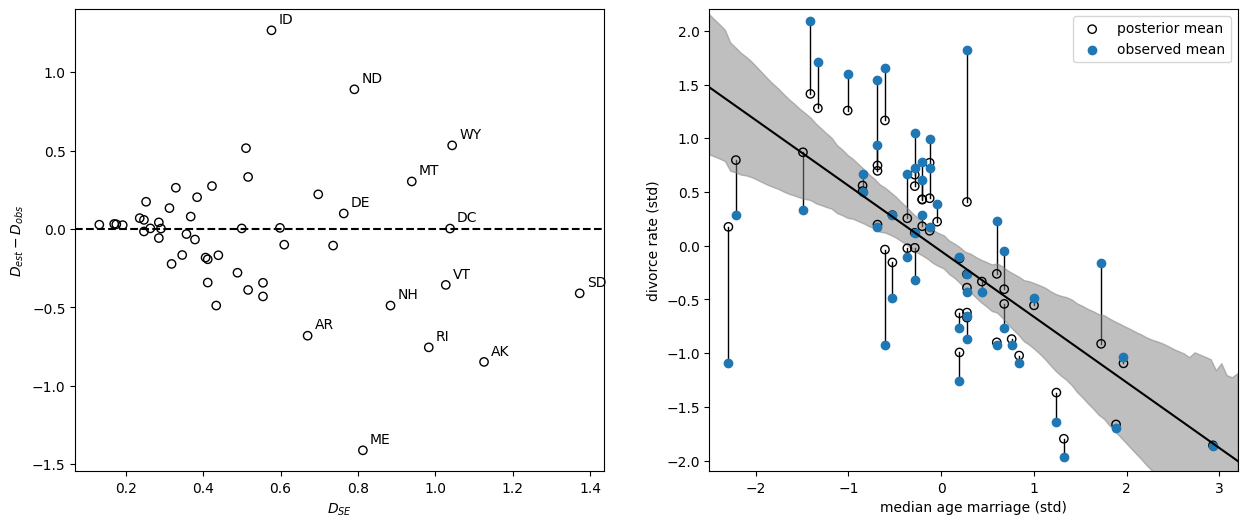

In [11]:
s = m15_1.get_samples()
df = divorce_df
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# shrinkage as a function of the measurement error
plt.sca(axes[0])
x = data["D_SE"]
y = s["D"].mean(dim=0) - data["D_obs"]
plt.scatter(x, y, facecolor="none", edgecolor="black")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel(r"$D_{SE}$")
plt.ylabel(r"$D_{est} - D_{obs}$")
mask = (x**2 + y**2 > 0.75**2).numpy()
for i in np.arange(len(mask))[mask]:
    plt.annotate(df.iloc[i]["Loc"], (x[i], y[i]), xytext=(5,5 ), textcoords="offset points")
# compare estimates before/after inference
plt.sca(axes[1])
# posterior regression line
x = torch.linspace(-2.5, 3.2, steps=100)
reg = s["α"][:,None] + s["βA"][:,None]*x[None,:]
mu = reg.mean(dim=0)
q = hpdi(reg, 0.89, dim=0)
plt.plot(x, mu, color="black")
plt.fill_between(x, *q, color="grey", alpha=0.5)
# posterior estimates for data points
x = data["A"]
y = s["D"].mean(dim=0)
plt.scatter(x, y, facecolor="none", edgecolor="black", label="posterior mean")
plt.scatter(x, data["D_obs"], color="C0", label="observed mean") # actual data points
# draw lines between data points
for i in range(len(y)):
    plt.plot(2*[x[i]], [y[i], data["D_obs"][i]], color="black", linewidth=1, zorder=-1)
plt.ylim(bottom=-2.1, top=2.2)
plt.xlim(left=-2.5, right=3.2)
plt.xlabel("median age marriage (std)")
plt.ylabel("divorce rate (std)")
plt.legend()
plt.show()

Can we also account for uncertainty in the predictor variables themselves? Of course! We just need to do the same thing - create some unobserved "true" predictor variable that feeds into the observed value. Our divorce dataset has uncertainty on the marriage rate as well, so let's introduce a "true" marriage rate $M$ and the observed rate $M_\text{obs}$, which is influenced by some outside error process $e_M$.

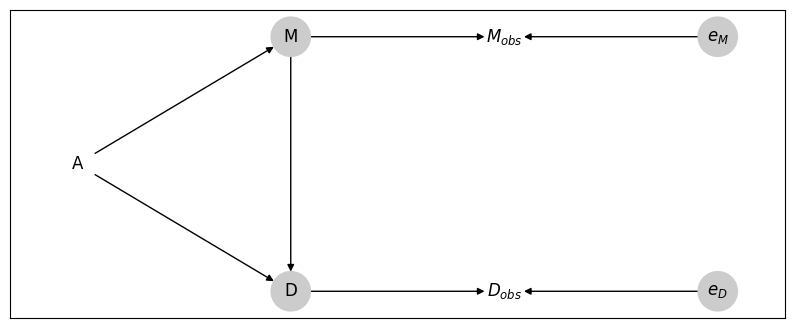

In [12]:
plt.figure(figsize=(10, 4))
G = nx.DiGraph()
G.add_nodes_from([
    ("A", dict(pos=(0, 0.5), color="white")),
    ("M", dict(pos=(1, 1), color="#cccccc")),
    ("D", dict(pos=(1, 0), color="#cccccc")),
    ("Dobs", dict(pos=(2, 0), color="white", label=r"$D_{obs}$")),
    ("eD", dict(pos=(3, 0), color="#cccccc", label=r"$e_D$")),
    ("Mobs", dict(pos=(2, 1), color="white", label=r"$M_{obs}$")),
    ("eM", dict(pos=(3, 1), color="#cccccc", label=r"$e_M$"))
])
G.add_edges_from([("A","M"), ("M","D"), ("A","D"), ("D","Dobs"), ("eD","Dobs"), ("M","Mobs"), ("eM","Mobs")])

c = nx.get_node_attributes(G, "color").values()
pos = nx.get_node_attributes(G, "pos")
labels = {n: G.nodes[n].get("label", n) for n in G.nodes}
nx.draw_networkx(G, pos, labels=labels, node_color=c, node_size=800)
plt.show()

We can then update our model to include this new source of error:

$$\begin{align*}
D_{\text{obs},i} &\sim \text{Normal}(D_{True, i}, D_{\text{SE},i}) \\
D_{True, i} &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i + \beta_M M_{True, i} \\
M_{\text{obs},i} &\sim \text{Normal}(M_{True, i}, M_{\text{SE},i}) \\
M_{True, i} &\sim \text{Normal}(0, 1) \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_A, \beta_M &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}$$

In [13]:
def standardize(x):
    return (x - x.mean())/x.std()

df = divorce_df
data = {
    "N": len(df),
    "D_obs": standardize(tt(df["Divorce"].values).double()),
    "D_SE": (tt(df["Divorce SE"].values)/tt(df["Divorce"].values).std()).double(),
    "A": standardize(tt(df["MedianAgeMarriage"].values).double()),
    "M_obs": standardize(tt(df["Marriage"].values).double()),
    "M_SE": (tt(df["Marriage SE"].values)/tt(df["Marriage"].values).std()).double(),
}

In [14]:
def model_m15_2(data, training=False):
    a = pyro.sample("α", Normal(0., 0.2))
    bA = pyro.sample("βA", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    sigma = pyro.sample("σ", Exponential(1.)).float()
    M = pyro.sample("M", Normal(0., 1.).expand([data["N"]]))
    mu = (a + bA*data["A"] + bM*M).float()
    D = pyro.sample("D", Normal(mu, sigma))
    if training:
        pyro.sample("M_obs", Normal(M, data["M_SE"]), obs=data["M_obs"])
        pyro.sample("D_obs", Normal(D, data["D_SE"]), obs=data["D_obs"])
    else:
        Mobs = pyro.sample("M_obs", Normal(M, data["M_SE"]))
        Dobs =  pyro.sample("D_obs", Normal(D, data["D_SE"]))
        return Mobs, Dobs

In [15]:
m15_2 = train_nuts(model_m15_2, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:20, 121.20it/s, step size=2.77e-01, acc. prob=0.907]


We can see that the strength of the relationship between $A$ and $D$ has been slightly reduced, and now there is perhaps a slight positive association between $M$ and $D$ that was not there before. But these changes on the regression parameters are only slight. The main change comes from the updated estimates for the marriage rate.

In [16]:
m15_2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      D[0]      1.14      0.37      1.13      0.54      1.75   3075.39      1.00
      D[1]      0.74      0.53      0.73     -0.17      1.54   2343.95      1.00
      D[2]      0.42      0.34      0.43     -0.10      0.99   3758.17      1.00
      D[3]      1.45      0.47      1.44      0.70      2.27   2888.89      1.00
      D[4]     -0.90      0.12     -0.90     -1.08     -0.70   3543.97      1.00
      D[5]      0.69      0.39      0.67      0.08      1.34   3229.30      1.00
      D[6]     -1.35      0.36     -1.34     -1.96     -0.79   4275.98      1.00
      D[7]     -0.27      0.47     -0.28     -1.07      0.50   1953.52      1.00
      D[8]     -1.77      0.57     -1.78     -2.67     -0.81   2072.77      1.00
      D[9]     -0.62      0.17     -0.62     -0.90     -0.35   4190.41      1.00
     D[10]      0.77      0.28      0.76      0.33      1.23   2960.74      1.00
     D[11]     -0.47      0

Once again, we can observe shrinkage of the variables towards the regression line, but now in two dimensions!

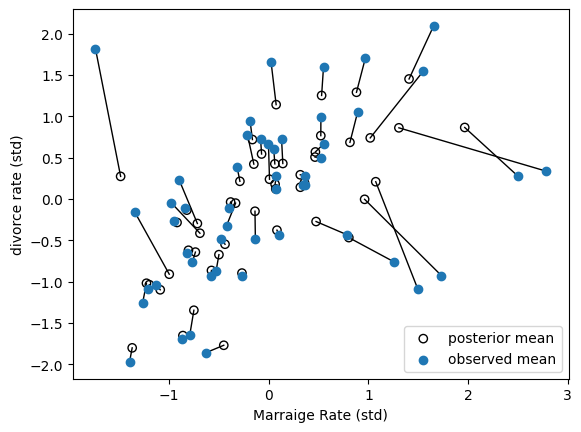

In [17]:
# compare estimates before/after inference
s = m15_2.get_samples()
# posterior estimates for data points
x = s["M"].mean(dim=0)
y = s["D"].mean(dim=0)
plt.scatter(x, y, facecolor="none", edgecolor="black", label="posterior mean")
plt.scatter(data["M_obs"], data["D_obs"], color="C0", label="observed mean") # actual data points
# draw lines between data points
for i in range(len(y)):
    plt.plot([x[i], data["M_obs"][i]], [y[i], data["D_obs"][i]], color="black", linewidth=1, zorder=-1)
plt.xlabel("Marraige Rate (std)")
plt.ylabel("divorce rate (std)")
plt.legend()
plt.show()

In the above examples, type of measurement error is assumed to be pretty benign. But there are ways in which the errors themselves could end up confounding measurements! For example, the two measurements errors not be independent, and instead both depend on some other factor:

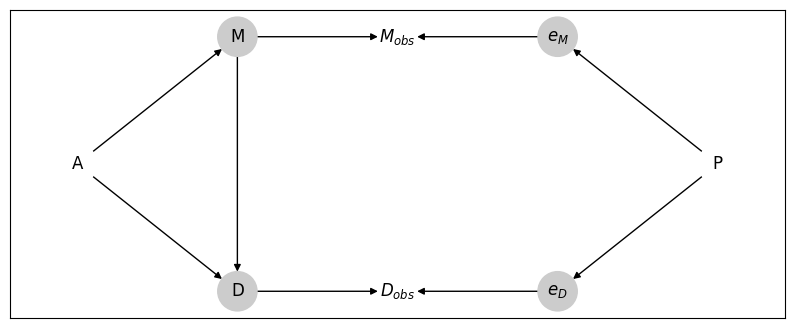

In [18]:
plt.figure(figsize=(10, 4))
G = nx.DiGraph()
G.add_nodes_from([
    ("A", dict(pos=(0, 0.5), color="white")),
    ("M", dict(pos=(1, 1), color="#cccccc")),
    ("D", dict(pos=(1, 0), color="#cccccc")),
    ("Dobs", dict(pos=(2, 0), color="white", label=r"$D_{obs}$")),
    ("eD", dict(pos=(3, 0), color="#cccccc", label=r"$e_D$")),
    ("Mobs", dict(pos=(2, 1), color="white", label=r"$M_{obs}$")),
    ("eM", dict(pos=(3, 1), color="#cccccc", label=r"$e_M$")),
    ("P", dict(pos=(4, 0.5), color="white")),
])
G.add_edges_from([
    ("A","M"), ("M","D"), ("A","D"), ("D","Dobs"), ("eD","Dobs"), ("M","Mobs"),
    ("eM","Mobs"), ("P", "eM"), ("P", "eD")
])

c = nx.get_node_attributes(G, "color").values()
pos = nx.get_node_attributes(G, "pos")
labels = {n: G.nodes[n].get("label", n) for n in G.nodes}
nx.draw_networkx(G, pos, labels=labels, node_color=c, node_size=800)
plt.show()

If $P$ is unobserved, then there is an open non-causal path through it that can confound our attempt to regress $D$ on $M$. We can potentially side-step this by considering the covariance between $e_M$ and $e_D$ like we did in the section on instrumental variables.

Another situation can arise when one of our regressors influences the error itself!

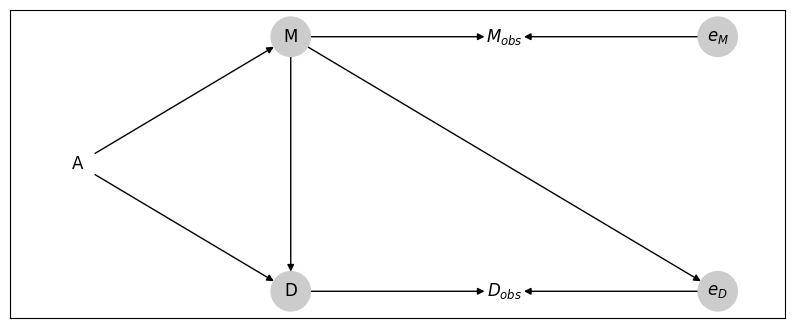

In [19]:
plt.figure(figsize=(10, 4))
G = nx.DiGraph()
G.add_nodes_from([
    ("A", dict(pos=(0, 0.5), color="white")),
    ("M", dict(pos=(1, 1), color="#cccccc")),
    ("D", dict(pos=(1, 0), color="#cccccc")),
    ("Dobs", dict(pos=(2, 0), color="white", label=r"$D_{obs}$")),
    ("eD", dict(pos=(3, 0), color="#cccccc", label=r"$e_D$")),
    ("Mobs", dict(pos=(2, 1), color="white", label=r"$M_{obs}$")),
    ("eM", dict(pos=(3, 1), color="#cccccc", label=r"$e_M$")),
])
G.add_edges_from([
    ("A","M"), ("M","D"), ("A","D"), ("D","Dobs"), ("eD","Dobs"), ("M","Mobs"),
    ("eM","Mobs"), ("M", "eD")
])

c = nx.get_node_attributes(G, "color").values()
pos = nx.get_node_attributes(G, "pos")
labels = {n: G.nodes[n].get("label", n) for n in G.nodes}
nx.draw_networkx(G, pos, labels=labels, node_color=c, node_size=800)
plt.show()

A scenario like this might occur if low marriage causes the error to be higher because there are less people to sample. I don't know if that is true, but we did see above, that the standard error on $D$ is actually negatively correlated with the population of the state; if we used population as a covariate, then that would introduce this type of error.

Finally, there is the scenario in which a causal variable is measured less precisely than a non-causal variable. For example, suppose we know $M$ and $D$ very precisely, but there is a good deal of measurement error on $A$:

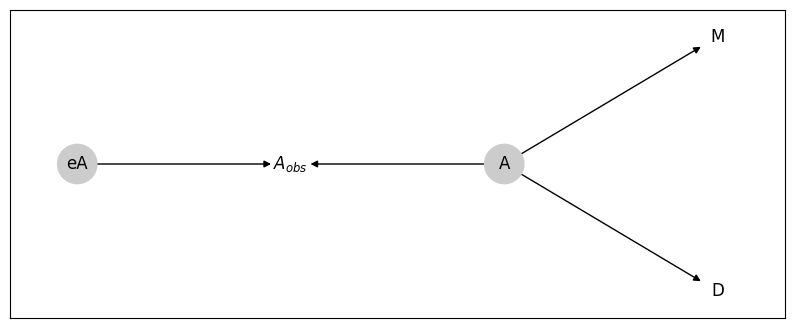

In [20]:
plt.figure(figsize=(10, 4))
G = nx.DiGraph()
G.add_nodes_from([
    ("eA", dict(pos=(0, 0.5), color="#cccccc")),
    ("Aobs", dict(pos=(1, 0.5), color="white", label=r"$A_{obs}$")),
    ("A", dict(pos=(2, 0.5), color="#cccccc")),
    ("M", dict(pos=(3, 1), color="white")),
    ("D", dict(pos=(3, 0), color="white")),
])
G.add_edges_from([("eA","Aobs"), ("A","Aobs"), ("A","M"), ("A","D")])

c = nx.get_node_attributes(G, "color").values()
pos = nx.get_node_attributes(G, "pos")
labels = {n: G.nodes[n].get("label", n) for n in G.nodes}
nx.draw_networkx(G, pos, labels=labels, node_color=c, node_size=800)
plt.show()

In this case, since our measurement of $A$ is noisy, $M$ actually is a better proxy for $A$ than $A_\text{obs}$ is itself! If they are correlated, then measuring $M$ can reveal a lot more about $A$ than $A_\text{obs}$ can. Here's a small simulation that produces such an effect:

In [21]:
N = 500
A = Normal(0., 1.).sample([N])
M = Normal(-A, 0.5).sample()
D = Normal(A, 0.5).sample()
A_obs = Normal(A, 1.).sample()

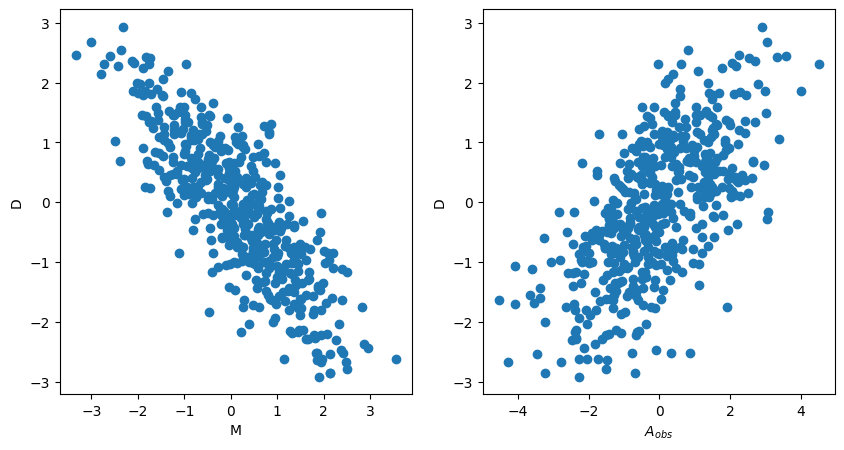

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
plt.sca(axes[0])
plt.scatter(M, D)
plt.xlabel("M")
plt.ylabel("D")
plt.sca(axes[1])
plt.scatter(A_obs, D)
plt.xlabel(r"$A_{obs}$")
plt.ylabel("D")
plt.show()